
# Hierarchical Risk Parity in Python

## Basic configuration

In [7]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
%matplotlib inline

---
## Reading files

In [23]:
from os import listdir
import pandas as pd
import pickle
from os.path import isfile, join
onlyfiles = [f for f in listdir("Data/Stocks/") if isfile(join("Data/Stocks/", f))]
print(len(onlyfiles))
onlyfiles = onlyfiles[:500]

7195


In [24]:
df = pd.DataFrame()
for file_x in onlyfiles:
    try:
        to_remove = pd.read_csv('Data/Stocks/'+ file_x)
        if to_remove.shape[0] >= 501:
            df[file_x.replace('.txt','')] = ((to_remove.Close.iloc[1:501].values-to_remove.Close.iloc[:500].values)/to_remove.Close.iloc[:500].values)
    except:
        pass
print df.shape

(500, 388)


In [25]:
df.to_csv("Data/Exported/series.csv")
df.cov().to_csv("Data/Exported/cov.csv")
df.corr().to_csv("Data/Exported/corr.csv")

---
## Model

In [26]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd 

In [27]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov) 
    ivp/=ivp.sum() 
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems] # matrix slice 
    w_=getIVP(cov_).reshape(-1,1) 
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0] 
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]]) 
    numItems=link[-1,3] # number of original items 
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space 
        df0=sortIx[sortIx>=numItems] # find clusters 
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1) 
        sortIx=sortIx.append(df0) # item 2 
        sortIx=sortIx.sort_index() # re-sort 
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()
#———————————————————————————————————————

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)/2), \
                                               (len(i)/2,len(i))) if len(i)>1] # bi-section
        for i in xrange(0,len(cItems),2): # parse in pairs 
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2 
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2 
    return w
#———————————————————————————————————————

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1 # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist
#———————————————————————————————————————

def plotCorrMatrix(path,corr,labels=None): # Heatmap of the correlation matrix
    if labels is None:labels=[] 
    mpl.pcolor(corr)
    mpl.colorbar() 
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels) 
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels) 
    #mpl.savefig(path)
    mpl.show()
    mpl.clf();mpl.close() # reset pylab
    return

In [28]:
list_from_r = [8,16,14,2,1,6,7,3,13,10,12,15,5,9,4,11]
list_from_r = [i - 1 for i in list_from_r]

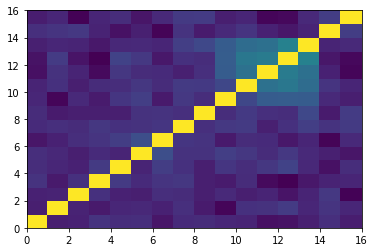

In [29]:
mpl.pcolor(df.corr().iloc[list_from_r, list_from_r])

In [30]:
def plot(link):
    # calculate full dendrogram
    mpl.figure(figsize=(25, 10))
    mpl.title('Hierarchical Clustering Dendrogram')
    mpl.xlabel('sample index')
    mpl.ylabel('distance')
    sch.dendrogram(
        link,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    mpl.show()

In [ ]:
def main():
    cov,corr=df.cov(),df.corr()
    #2) compute and plot correl matrix 
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns) 
    
    #3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    plot(link)
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels 
    df0=corr.loc[sortIx,sortIx] # reorder 
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx) 
    return hrp, df0

---
## Result

In [ ]:
hrp, corr = main()

In [ ]:
hrp.sum()

In [ ]:
def anualized(row):
    anual = 1
    for i in row.values:
        anual = (anual)*(i+1)
    anual -= 1
    return anual

In [ ]:
(df.apply(axis=0, func=anualized)*hrp).sum()

In [ ]:
pickle.dump(hrp, open("outputs/3000stocks_hrp.p", 'wb'))
pickle.dump(df, open("outputs/3000stocks_df.p", 'wb'))
pickle.dump(corr, open("outputs/3000stocks_corr.p", 'wb'))